# Team Based Model

## Imports

In [172]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.multioutput import MultiOutputRegressor

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [3]:
team_data = load_team_data()

In [4]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)

In [5]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [6]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [7]:
from src.data import make_team_dataset

matchups = make_team_dataset.create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [8]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]


In [9]:
avg_data

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,115.2,242.5,0.6,28.6,54.6,13.5,38.4,17.5,22.7,9.3,34.0,43.3,25.0,9.3,6.9,15.3,22.7,115.2,1.0,105.67,107.63,103.95,107.11,1.74,0.51,107.0,0.4942,6.1,17.0,21.0,50.7,14.4,13.5,9.8,3.1
51340,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901278,2020-08-07,NOP vs. WAS,1,118,11,1,242.5,0.4,31.7,58.4,11.7,33.7,17.3,25.3,11.7,35.9,47.6,28.3,8.1,3.5,17.5,21.1,115.8,-1.6,106.33,109.58,108.91,110.73,-2.60,-1.14,105.7,0.5030,8.5,14.6,14.7,54.4,17.2,13.6,10.1,0.8,117.4,242.5,0.6,28.8,54.8,13.8,37.3,18.4,23.9,9.2,32.9,42.1,24.9,9.4,6.0,14.5,22.7,117.4,1.6,108.91,110.73,106.33,109.58,2.60,1.14,10

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [10]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [11]:
avg_data_2 = add_percentage_features(avg_data)


In [12]:
avg_data_3 = add_rest_days(avg_data_2)
avg_data_3

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,0.257642,0.800429,0.531385,0.581348,0.520541,26.547842,14.621324,242.5,0.6,28.6,54.6,1

In [71]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(avg_data_3, avg_data_3, on='GAME_ID')
full_df = full_df.loc[full_df['TEAM_ABBREVIATION_team_x'] != full_df['TEAM_ABBREVIATION_team_y']]

# new_cols = []
# for col in full_df.columns:
#     if col.endswith('_x'):
#         col = col[:-2]
#     if col.endswith('_y'):
#         col = col[:-2] + '_opp'
#     if col.endswith('_team'):
#         col = col[:-5]
        
#     new_cols.append(col)
    
# full_df.columns = new_cols


columns = full_df.columns.tolist()
columns.remove('TEAM_SCORE_team_y')
columns.insert(10, 'TEAM_SCORE_team_y')

full_df = full_df[columns]
full_df = full_df.drop(columns=['SEASON_YEAR_team_y','SEASON_ID_team_y','TEAM_ID_team_y','TEAM_ABBREVIATION_team_y','TEAM_NAME_team_y',
                                'GAME_DATE_team_y','MATCHUP_team_y','HOME_GAME_team_y','point_diff_team_y','WL_team_y'])
full_df = full_df.reset_index(drop=True)

full_df = full_df.rename(columns = {'SEASON_YEAR_team_x':'SEASON_YEAR',
                          'SEASON_ID_team_x':'SEASON_ID',
                          'TEAM_ID_team_x':'TEAM_ID',
                          'TEAM_ABBREVIATION_team_x':'TEAM_ABBREVIATION',
                          'TEAM_NAME_team_x':'TEAM_NAME_team',
                          'GAME_ID':'GAME_ID',
                          'GAME_DATE_team_x':'GAME_DATE',
                          'MATCHUP_team_x':'MATCHUP'})

full_df.sort_values(['GAME_DATE', 'GAME_ID'])
                                    
                                    


,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y
1458,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,2000-01,22000,16106

## Add ELO Rating

In [72]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [73]:
def get_elo_ratings(df = full_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['TEAM_SCORE_team_x']
        opp_score = row['TEAM_SCORE_team_y']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team_x'] == 1:
            team_rating_temp = team_rating + 100
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 100
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return None

get_elo_ratings(df = full_df)

progress:: 51344it [01:44, 493.57it/s]


In [74]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359935,1300.000000,1329.684174,1300.000000,1270.315826,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [44]:
full_df.loc[(full_df['TEAM_ABBREVIATION'] == 'LAL') & (full_df['SEASON_YEAR'] == '2019-20'), ['GAME_ID', 'GAME_DATE', 'MATCHUP', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

,GAME_ID,GAME_DATE,MATCHUP,TEAM_SCORE_team_x,TEAM_SCORE_team_y,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n
49063,21900002,2019-10-22,LAL @ LAC,102,112,1464.194457,1459.021225,1526.819564,1531.992795
49109,21900025,2019-10-25,LAL vs. UTA,95,86,1459.021225,1469.789198,1612.941665,1602.173693
49138,21900040,2019-10-27,LAL vs. CHA,120,101,1469.789198,1480.138127,1465.737611,1455.388682
49166,21900054,2019-10-29,LAL vs. MEM,120,91,1480.138127,1490.425654,1410.688375,1400.400848
49207,21900074,2019-11-01,LAL @ DAL,119,110,1490.425654,1501.907650,1486.833497,1475.351501
49235,21900088,2019-11-03,LAL @ SAS,103,96,1501.907650,1512.843791,1591.349549,1580.413409
49258,21900100,2019-11-05,LAL @ CHI,118,112,1512.843791,1518.261712,1324.223435,1318.805513
49310,21900126,2019-11-08,LAL vs. MIA,95,80,1518.261712,1528.490960,1548.593652,1538.364404
49336,21900139,2019-11-10,LAL vs. TOR,104,113,1528.490960,1520.383980,1705.670705,1713.777685
49360,21900151,2019-11-12,LAL @ PHX,123,115,1520.383980,1528.427801,1388.517238,1380.473417


In [60]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,home_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,team_elo_pred,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,72,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1300.000000,1329.684174,1300.000000,1270.315826,0.359935,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,101,-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Add Betting Data

In [45]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread

,away_team,home_team,game_date,away_scoreboard,home_scoreboard,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,CHI,MIA,2006-10-31,"'22', '37', '21', '28', '108'","'16', '14', '21', '15', '66'",4.5,NaN,4.5,NaN,-4.5,NaN,-4.5,NaN,4.5,-4.5
1,PHX,LAL,2006-10-31,"'41', '17', '21', '27', '106'","'26', '27', '34', '27', '114'",-8.5,NaN,-8.0,NaN,8.5,NaN,8.0,NaN,-8.5,8.0
2,ATL,PHI,2006-11-01,"'14', '21', '23', '17', '75'","'29', '20', '24', '15', '88'",6.0,NaN,5.5,NaN,-6.0,NaN,-5.5,NaN,5.5,-6.0
3,NOP,BOS,2006-11-01,"'26', '28', '21', '16', '91'","'16', '25', '24', '22', '87'",3.5,NaN,3.0,NaN,-3.5,NaN,-3.0,NaN,3.0,-3.5
4,TOR,BKN,2006-11-01,"'27', '22', '21', '22', '92'","'28', '25', '21', '28', '102'",7.0,NaN,7.5,NaN,-7.0,NaN,-7.5,NaN,7.0,-7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,CLE,ATL,2021-03-14,NaN,NaN,5.5,5.5,5.5,5.5,-5.5,-5.5,-5.5,-5.5,5.5,-5.5
18272,BOS,HOU,2021-03-14,NaN,NaN,-11.0,-11.0,-10.5,-11.0,11.0,11.0,10.5,11.0,-11.0,11.0
18273,POR,MIN,2021-03-14,NaN,NaN,-5.0,-5.0,-5.0,-5.0,5.0,5.0,5.0,5.0,-5.0,5.0
18274,TOR,CHI,2021-03-14,NaN,NaN,3.0,3.0,3.0,3.0,-3.0,-3.0,-3.0,-3.0,3.0,-3.0


## Helper Functions for Bet Simulations

In [46]:
def simulate_bets(selected_bets, unit_size=0.01):
    """This function simulates betting unit_size (default 1%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [47]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [161]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(test_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    results = final_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    for i in range(1, 20):
        for j in range(0, i):
            select_bets = betting_df.loc[abs(betting_df['confidence']).between(j, i)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((j, i))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('num_games_bet', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    best_thresholds = confidence_thresholds.loc[0, 'confidence_range']
    print("best thresholds:", best_thresholds)
    select_bets = betting_df.loc[abs(betting_df['confidence']).between(best_thresholds[0], best_thresholds[1])]  
    print("num_games_bet:", select_bets.shape[0])
    print("win percetange at threshold:", select_bets['bet_won'].mean())
    
    return select_bets, confidence_thresholds
    



In [ ]:
def find_optimal_spreads(test_preds, test_indices):
    results = final_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
    results['pred'] = test_preds
    home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
    away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
    results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
    results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
    results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                                  'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

    results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
           'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


    spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
    betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
    betting_df.rename(columns={'home_spread_mode':'spread',
                              'TEAM_ABBREVIATION_home':'home_team',
                              'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]

    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

    betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df

In [49]:
def bet_selector(test_preds, test_indices, low, high):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    spread = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]

    betting_df = pd.merge(full_df[['GAME_DATE', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE']], spread, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION'], right_on=['game_date', 'home_team'])
    betting_df = betting_df.drop(columns=['TEAM_ABBREVIATION', 'MATCHUP', 'game_date'])
    betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'point_diff', 'home_spread_mode']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
    betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[test_indices]
    betting_df[['home_score_pred', 'away_score_pred']] = test_preds

    betting_df['point_diff_pred'] = betting_df['home_score_pred'] - betting_df['away_score_pred']
    betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
    betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

    betting_df = betting_df.dropna()
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    
    selected_bets = betting_df.loc[abs(betting_df['confidence']).between(low, high)]
    return selected_bets


In [50]:
def train_model():
    features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 
                        'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp',
                       'HOME_EFG_PCT', 'HOME_EFG_PCT_opp', 'AWAY_EFG_PCT', 'AWAY_EFG_PCT_opp']]
    point_diff = full_df['point_diff']
    win = full_df['WL']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:cutoffs[i+1]]
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

        pipeline.fit(X_train, point_diff_train)
        lr_preds = pipeline.predict(X_test)

        mse = mean_squared_error(point_diff_test, lr_preds)
        mae = mean_absolute_error(point_diff_test, lr_preds)
        print("season {}".format(i+2015))
        print("mse:", mse, "mae:", mae)
        print(list(zip(features.columns, pipeline.named_steps['linreg'].coef_)))
        
        if i == len(cutoffs) - 1:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:]
            
        else:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_preds'] = lr_preds
        betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
        betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
        betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])
        
        select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

## Testing Models

In [81]:
final_df = full_df.sort_values('GAME_DATE').reset_index(drop=True)
final_df = final_df.dropna()
final_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME_team,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME_team_x,TEAM_SCORE_team_x,TEAM_SCORE_team_y,point_diff_team_x,WL_team_x,MIN_team_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
142,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.0,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.593193,1299.375397,1305.879221,1333.852404,1327.348580,-1.23
143,2000-01,22000,1610612757,POR,Portland Trail Blazers,20000078,2000-11-09,POR vs. DEN,1,107,91,16,1,240.0,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,240.0,0.6,29

In [84]:
features

,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,MIN_opp_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,MIN_team_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,MIN_opp_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred,HOME_GAME
142,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.0,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.593193,1299.375397,1305.879221,1333.852404,1327.348580,-1.23,1
143,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,240.0,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,245.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,

### Creating Feature Dataset

In [179]:
features = final_df.iloc[:, 13:]
features['HOME_GAME'] = final_df['HOME_GAME_team_x']
features = features.drop(columns=['MIN_team_x', 'MIN_opp_x', 'MIN_team_y', 'MIN_opp_y', 'team_rating_n', 'opp_rating_n'])
score = final_df['TEAM_SCORE_team_x']

cutoff_15 = int(final_df[final_df['SEASON_YEAR'] == '2015-16'].index[0])
cutoff_16 = int(final_df[final_df['SEASON_YEAR'] == '2016-17'].index[0])
cutoff_17 = int(final_df[final_df['SEASON_YEAR'] == '2017-18'].index[0])
cutoff_18 = int(final_df[final_df['SEASON_YEAR'] == '2018-19'].index[0])
cutoff_19 = int(final_df[final_df['SEASON_YEAR'] == '2019-20'].index[0])

cutoffs = [cutoff_15, cutoff_16, cutoff_17, cutoff_18, cutoff_19]

tscv = TimeSeriesSplit()

X_train = features.loc[:cutoff_15]
X_test = features.loc[cutoff_15:]
score_train = score.loc[:cutoff_15]
score_test = score.loc[cutoff_15:]
test_indices = X_test.index
print(X_train.shape, X_test.shape, score_train.shape, score_test.shape)

features

(36183, 167) (11996, 167) (36183,) (11996,)


,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
142,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.593193,1299.375397,1333.852404,-1.23,1
143,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.286364,0.687179,0.474699,0.555482,0.467857,23.828921,13.337601,0.6,35.2,

### Linear Regression Pipeline

In [89]:
lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline.fit(X_train, score_train)
lr_preds = lr_pipeline.predict(X_test)

mse_lr = mean_squared_error(score_test, lr_preds)
mae_lr = mean_absolute_error(score_test, lr_preds)
print("mse_home:", mse_lr)
print("mae_home:", mae_lr)

lr_preds

mse_home: 132.10088010144568
mae_home: 9.07905307696611


array([ 98.26153665, 100.47559154, 111.77169789, ..., 107.68853039,
       111.0455933 , 110.49427577])

In [158]:
results = final_df.loc[test_indices, ['GAME_DATE', 'HOME_GAME_team_x', 'GAME_ID', 'TEAM_ABBREVIATION', 'MATCHUP', 'point_diff_team_x', 'TEAM_SCORE_team_x', 'TEAM_SCORE_team_y']]
results['pred'] = lr_preds
home_teams = results.loc[results['HOME_GAME_team_x'] == 1]
away_teams = results.loc[results['HOME_GAME_team_x'] == 0]
results = pd.merge(home_teams, away_teams[['TEAM_ABBREVIATION', 'GAME_ID', 'pred']], on='GAME_ID', suffixes=['_home', '_away'])
results = results.drop(columns=['HOME_GAME_team_x', 'GAME_ID'])
results.rename(columns={'point_diff_team_x':'point_diff', 'TEAM_SCORE_team_x':'HOME_SCORE',
                              'TEAM_SCORE_team_y':'AWAY_SCORE'}, inplace=True)

results = results[['GAME_DATE', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'MATCHUP', 'point_diff',
       'HOME_SCORE', 'AWAY_SCORE', 'pred_home', 'pred_away']]


spreads = clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode']]
betting_df = pd.merge(results, spreads, how='left', left_on=['GAME_DATE', 'TEAM_ABBREVIATION_home'], right_on=['game_date', 'home_team'])
betting_df = betting_df.drop(columns=['away_team', 'home_team', 'game_date', 'MATCHUP'])
betting_df.rename(columns={'home_spread_mode':'spread',
                          'TEAM_ABBREVIATION_home':'home_team',
                          'TEAM_ABBREVIATION_away':'away_team'}, inplace=True)

betting_df = betting_df[['GAME_DATE', 'home_team', 'away_team', 'spread', 'HOME_SCORE', 'AWAY_SCORE', 'point_diff', 'pred_home', 'pred_away']]
                         
betting_df['home_cover'] = (betting_df['point_diff'] + betting_df['spread'] > 0).astype(int)
betting_df.loc[betting_df['point_diff'] + betting_df['spread'] == 0, 'home_cover'] = 0.5

betting_df['point_diff_pred'] = betting_df['pred_home'] - betting_df['pred_away']
betting_df['bet_home'] = (betting_df['point_diff_pred'] + betting_df['spread'] > 0).astype(int)
betting_df['bet_won'] = (betting_df['home_cover'] == betting_df['bet_home']).astype(int)
betting_df['confidence'] = betting_df['point_diff_pred'] + betting_df['spread']

betting_df = betting_df.dropna()
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]

betting_df

,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence
0,2015-11-05,POR,MEM,4.5,115,96,19,100.475592,98.261537,1.0,2.214055,1,1,6.714055
1,2015-11-05,CHI,OKC,-1.0,104,98,6,111.216285,111.771698,1.0,-0.555413,0,0,-1.555413
2,2015-11-06,SAC,HOU,4.5,110,116,-6,106.619233,107.631778,0.0,-1.012545,1,0,3.487455
3,2015-11-06,GSW,DEN,-17.5,119,104,15,113.844459,97.222559,0.0,16.621899,0,1,-0.878101
5,2015-11-06,ORL,TOR,6.0,92,87,5,103.834246,108.542085,1.0,-4.707840,1,1,1.292160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,2020-10-02,LAL,MIA,-11.0,124,114,10,113.493891,107.230666,0.0,6.263225,0,1,-4.736775
5994,2020-10-04,MIA,LAL,9.5,115,104,11,110.902315,111.417298,1.0,-0.514983,1,1,8.985017
5995,2020-10-06,MIA,LAL,7.5,96,102,-6,111.841334,111.613831,1.0,0.227504,1,1,7.727504
5996,2020-10-09,LAL,MIA,-7.5,108,111,-3,114.179924,107.688530,0.0,6.491393,0,1,-1.008607


best thresholds: (5, 7)
num_games_bet: 447
win percetange at threshold: 0.5413870246085011


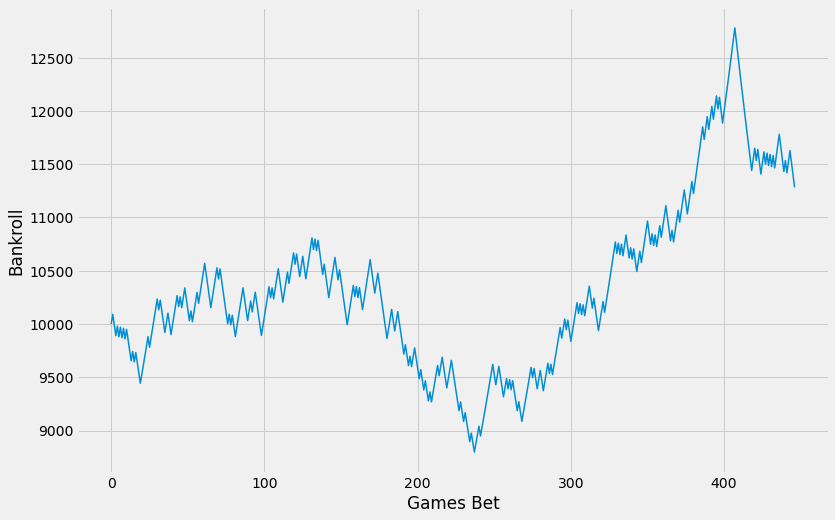

min balance: 8797.571502535608 
max balance: 12779.435819362468 
final balance: 11385.338587314465 
win percentage 54.14


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,0,2015-11-05,POR,MEM,4.5,115,96,19,100.475592,98.261537,1.0,2.214055,1,1,6.714055,10000.000000,100.000000,10090.909091
1,25,2015-11-09,PHI,CHI,10.5,88,111,-23,99.827964,103.888540,0.0,-4.060577,1,0,6.439423,10090.909091,100.909091,9990.000000
2,33,2015-11-10,WAS,OKC,6.5,101,125,-24,109.791692,110.974837,0.0,-1.183145,1,0,5.316855,9990.000000,99.900000,9890.100000
3,39,2015-11-11,ATL,NOP,-13.0,106,98,8,109.226483,101.660418,0.0,7.566065,0,1,-5.433935,9890.100000,98.901000,9980.010000
4,45,2015-11-12,PHX,LAC,-2.5,118,104,14,105.342264,108.004496,1.0,-2.662232,0,0,-5.162232,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,5941,2020-08-23,PHI,BOS,7.0,106,110,-4,113.814385,115.448644,1.0,-1.634260,1,1,5.365740,11523.377238,115.233772,11628.135213
443,5945,2020-08-24,POR,LAL,7.0,115,135,-20,111.937468,112.432452,0.0,-0.494984,1,0,6.505016,11628.135213,116.281352,11511.853861
444,5971,2020-09-08,HOU,LAL,4.5,102,112,-10,113.336589,112.370676,0.0,0.965913,1,0,5.465913,11511.853861,115.118539,11396.735323
445,5975,2020-09-10,HOU,LAL,5.5,100,110,-10,112.221897,111.973465,0.0,0.248432,1,0,5.748432,11396.735323,113.967353,11282.767969


In [162]:
select_bets_lr, best_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

In [93]:
# Save the Model to file
filename = "../models/linreg_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(lr_pipeline, file)
    


In [ ]:
select_bets_lr, best_thresholds_lr = find_optimal_threshold(lr_preds, test_indices)
simulate_bets(select_bets_lr)

#### RFE for Linear Regression

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [187]:
lr_rfe = RFECV(estimator = LinearRegression(), cv=tscv, n_jobs=-1, verbose=1)
lr_rfe.fit(X_train_scaled, score_train)

feature_mask = lr_rfe.support_
lr_reduced = lr_rfe.estimator_

X_test_reduced = X_test_scaled[:, feature_mask]

lr_reduced.fit(X_test_reduced, score_test)
lr_reduced_preds = lr_reduced.predict(X_test_reduced)


Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.


In [188]:
reduced_feature_names = X_train.iloc[:, feature_mask].columns
coefficients = lr_reduced.coef_[0]
coefficients.shape
coefs = pd.DataFrame({'feature':reduced_feature_names, 'coefficient':coefficients})
coefs

,feature,coefficient
0,RECORD_team_x,-0.089033
1,FG2M_team_x,-0.089033
2,FG2A_team_x,-0.089033
3,FG3M_team_x,-0.089033
4,FG3A_team_x,-0.089033
...,...,...
155,team_elo_pred,-0.089033
156,team_rating_i,-0.089033
157,opp_rating_i,-0.089033
158,elo_MOV_pred,-0.089033


best thresholds: (2, 5)
num_games_bet: 2339
win percetange at threshold: 0.5314236853356135


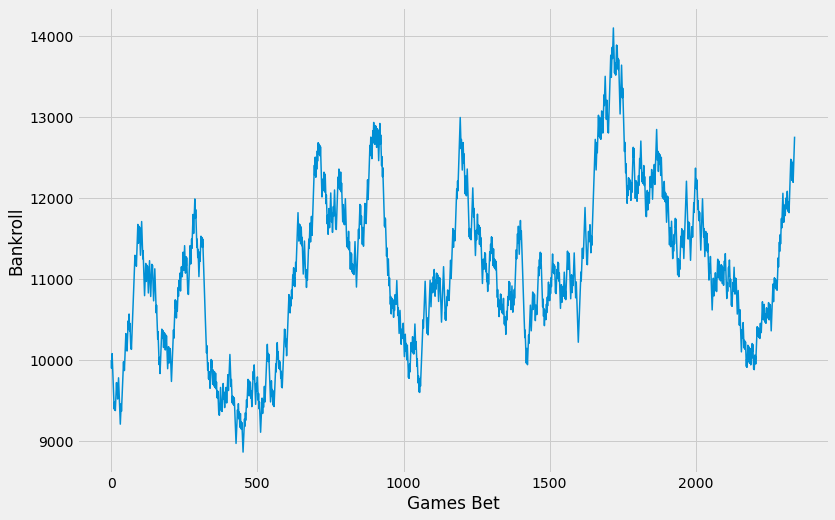

min balance: 8864.222314742889 
max balance: 14104.108007091612 
final balance: 12633.633067701838 
win percentage 53.14


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,1,2015-11-05,CHI,OKC,-1.0,104,98,6,107.773340,110.426573,1.0,-2.653233,0,0,-3.653233,10000.000000,100.000000,9900.000000
1,3,2015-11-06,GSW,DEN,-17.5,119,104,15,111.293059,97.345471,0.0,13.947588,0,1,-3.552412,9900.000000,99.000000,9990.000000
2,10,2015-11-07,UTA,MEM,-2.5,89,79,10,92.337521,85.937378,1.0,6.400143,1,1,3.900143,9990.000000,99.900000,10080.818182
3,13,2015-11-07,PHI,ORL,3.0,97,105,-8,102.624324,101.023738,0.0,1.600586,1,0,4.600586,10080.818182,100.808182,9980.010000
4,16,2015-11-08,OKC,PHX,-8.5,124,103,21,112.606861,107.259771,1.0,5.347090,0,0,-3.152910,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,5986,2020-09-22,DEN,LAL,6.0,114,106,8,104.881260,108.450969,1.0,-3.569709,1,1,2.430291,12307.557968,123.075580,12419.444858
2335,5990,2020-09-26,LAL,DEN,-5.5,117,107,10,108.056996,100.155684,1.0,7.901312,1,1,2.401312,12419.444858,124.194449,12532.348902
2336,5991,2020-09-27,MIA,BOS,3.0,125,113,12,108.965627,107.681234,1.0,1.284393,1,1,4.284393,12532.348902,125.323489,12646.279347
2337,5993,2020-10-02,LAL,MIA,-11.0,124,114,10,110.081187,103.032213,0.0,7.048975,0,1,-3.951025,12646.279347,126.462793,12761.245523


In [163]:
select_bets_lr_re, best_thresholds_lr_re = find_optimal_threshold(lr_reduced_preds, test_indices)
simulate_bets(select_bets_lr_re)

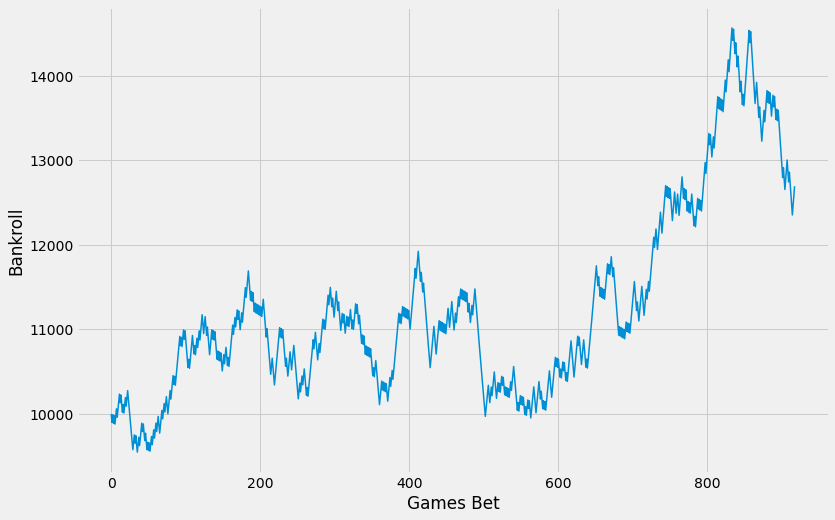

min balance: 9548.901102742737 
max balance: 14563.724535325724 
final balance: 12565.583511124132 
win percentage 53.92


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18091,2015-11-05,CHI,OKC,104,98,6,-1.0,1.0,107.364407,111.432231,-4.067824,0,0,-5.067824,10000.000000,100.000000,9900.000000
1,18092,2015-11-05,POR,MEM,115,96,19,4.5,1.0,105.757530,98.583461,7.174069,1,1,11.674069,9900.000000,99.000000,9990.000000
2,18094,2015-11-06,SAC,HOU,110,116,-6,4.5,0.0,107.444769,106.133803,1.310966,1,0,5.810966,9990.000000,99.900000,9890.100000
3,18099,2015-11-07,UTA,MEM,89,79,10,-2.5,1.0,98.958289,87.894601,11.063688,1,1,8.563688,9890.100000,98.901000,9980.010000
4,18114,2015-11-09,LAC,MEM,94,92,2,-7.0,0.0,105.829070,93.784030,12.045040,1,0,5.045040,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,24066,2020-09-10,HOU,LAL,100,110,-10,5.5,0.0,111.760465,107.776386,3.984079,1,0,9.484079,12477.322223,124.773222,12352.549001
914,24070,2020-09-13,DEN,LAC,111,98,13,8.5,1.0,104.999033,105.889346,-0.890313,1,1,7.609687,12352.549001,123.525490,12464.844901
915,24085,2020-10-04,MIA,LAL,115,104,11,9.5,1.0,105.657607,105.157315,0.500292,1,1,10.000292,12464.844901,124.648449,12578.161673
916,24086,2020-10-06,MIA,LAL,96,102,-6,7.5,1.0,106.301605,105.563442,0.738163,1,1,8.238163,12578.161673,125.781617,12692.508597


In [47]:
select_bets = bet_selector(lr_reduced_preds, test_indices, 5, 15)
select_bets
simulate_bets(select_bets)

### Elastic Net Pipeline

In [102]:
pipeline_en = Pipeline([('scaler', StandardScaler()),
                    ('en', ElasticNet(max_iter=5000))])

params = {'en__alpha':np.logspace(-1, 2, 10),
         'en__l1_ratio':np.linspace(0.05, 1, 20)}


en_gs = GridSearchCV(pipeline_en, param_grid=params, n_jobs=-1, cv=tscv, verbose=1)
en_gs.fit(X_train, score_train)

print("best estimator:", en_gs.best_estimator_)
print("best parameters:", en_gs.best_params_)
best_en = en_gs.best_estimator_
en_preds = best_en.predict(X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])
best parameters: {'en__alpha': 0.1, 'en__l1_ratio': 0.05}


In [169]:
best_en = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.1, l1_ratio=0.05, max_iter=5000))])


best_en.fit(X_train, score_train)
en_preds = best_en.predict(X_test)

In [190]:
feature_names = X_train.columns
en_coefs = best_en.named_steps['en'].coef_
coefs = pd.DataFrame({'feature':feature_names, 'coefficient':en_coefs})
coefs.sort_values('coefficient')

,feature,coefficient
164,opp_rating_i,-0.559789
66,PTS_FB_opp_x,-0.322572
93,BLK_team_y,-0.265122
52,BLK_opp_x,-0.213102
11,STL_team_x,-0.210050
...,...,...
144,POSS_opp_y,0.588666
26,PTS_FB_team_x,0.608247
165,elo_MOV_pred,0.614678
166,HOME_GAME,0.922838


best thresholds: (8, 10)
num_games_bet: 80
win percetange at threshold: 0.55


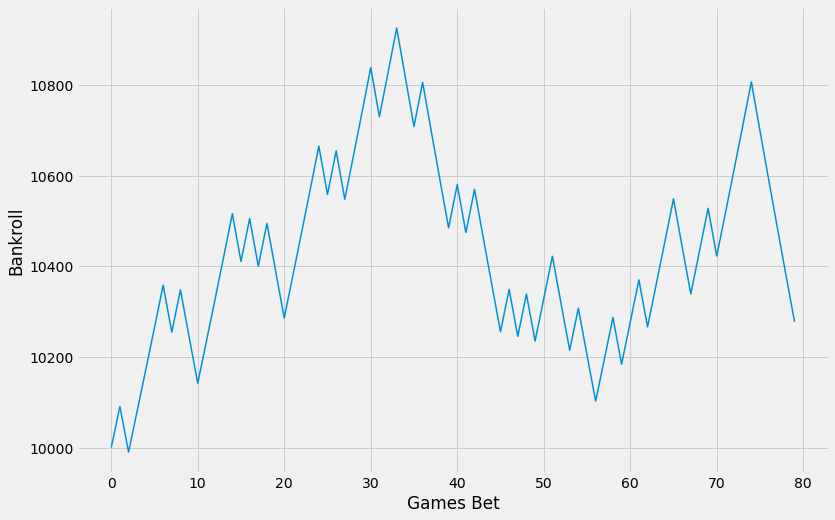

min balance: 9990.0 
max balance: 10925.808906698096 
final balance: 10370.505476222637 
win percentage 55.00000000000001


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,408,2015-12-31,HOU,GSW,-3.5,110,114,-4,107.365631,112.163243,0.0,-4.797612,0,1,-8.297612,10000.000000,100.000000,10090.909091
1,501,2016-01-13,OKC,DAL,-12.5,108,89,19,109.438990,104.982780,1.0,4.456210,0,0,-8.043790,10090.909091,100.909091,9990.000000
2,613,2016-01-28,NOP,SAC,5.5,114,105,9,108.526772,104.743719,1.0,3.783053,1,1,9.283053,9990.000000,99.900000,10080.818182
3,890,2016-03-11,MEM,NOP,3.0,121,114,7,110.247012,103.781402,1.0,6.465610,1,1,9.465610,10080.818182,100.808182,10172.461983
4,934,2016-03-17,MIL,MEM,-11.0,96,86,10,106.752794,104.607296,0.0,2.145498,0,1,-8.854502,10172.461983,101.724620,10264.938911
5,992,2016-03-24,IND,NOP,-14.0,92,84,8,108.350210,102.397401,0.0,5.952810,0,1,-8.047190,10264.938911,102.649389,10358.256537
6,1009,2016-03-26,NOP,TOR,11.5,91,115,-24,104.083892,107.156776,0.0,-3.072884,1,0,8.427116,10358.256537,103.582565,10254.673972
7,1099,2016-04-08,TOR,IND,4.5,111,98,13,101.868797,97.533764,1.0,4.335033,1,1,8.835033,10254.673972,102.546740,10347.898281
8,1101,2016-04-08,DEN,SAS,-1.0,102,98,4,94.395016,101.638663,1.0,-7.243647,0,0,-8.243647,10347.898281,103.478983,10244.419298
9,1113,2016-04-09,NOP,PHX,3.0,100,121,-21,106.150501,99.914251,0.0,6.236250,1,0,9.236250,10244.419298,102.444193,10141.975105


In [170]:
select_bets_en, best_thresholds_en = find_optimal_threshold(en_preds, test_indices)
simulate_bets(select_bets_en)

### Lasso Regression

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_cv = LassoCV(cv = tscv, max_iter=10000)

lasso_cv.fit(X_train_scaled, score_train)

best_alpha = lasso_cv.alpha_
print(best_alpha)

In [176]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.0122303788))])

pipeline_lasso.fit(X_train, score_train)
lasso_preds = pipeline_lasso.predict(X_test)


best thresholds: (4, 5)
num_games_bet: 472
win percetange at threshold: 0.5338983050847458


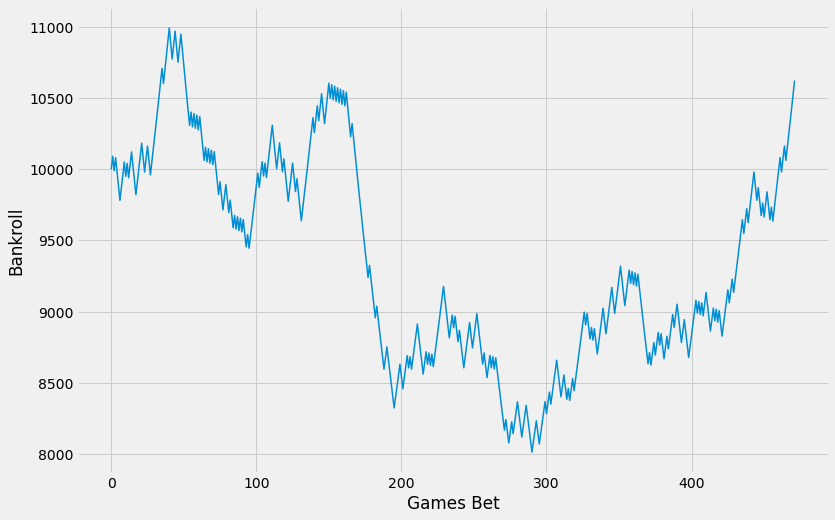

min balance: 8013.3737056649925 
max balance: 10992.092103265079 
final balance: 10719.55620762257 
win percentage 53.39


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,9,2015-11-07,SAC,GSW,14.0,94,103,-9,107.592283,116.732090,1.0,-9.139808,1,1,4.860192,10000.000000,100.000000,10090.909091
1,34,2015-11-11,POR,SAS,6.5,101,113,-12,100.399461,102.121031,0.0,-1.721570,1,0,4.778430,10090.909091,100.909091,9990.000000
2,48,2015-11-13,DEN,HOU,6.5,107,98,9,104.591007,106.571184,1.0,-1.980177,1,1,4.519823,9990.000000,99.900000,10080.818182
3,57,2015-11-13,TOR,NOP,-10.5,100,81,19,107.023625,101.342476,1.0,5.681149,0,0,-4.818851,10080.818182,100.808182,9980.010000
4,103,2015-11-20,OKC,NYK,-6.5,90,93,-3,106.310548,95.795036,0.0,10.515512,1,0,4.015512,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,5949,2020-08-29,MIL,ORL,-14.5,118,104,14,122.324815,111.828631,0.0,10.496183,0,1,-4.003817,10245.315520,102.453155,10338.454752
468,5950,2020-08-29,LAL,POR,-14.0,131,122,9,119.063512,109.869773,0.0,9.193738,0,1,-4.806262,10338.454752,103.384548,10432.440704
469,5956,2020-08-31,OKC,HOU,4.5,104,100,4,114.247336,113.965435,1.0,0.281901,1,1,4.781901,10432.440704,104.324407,10527.281074
470,5990,2020-09-26,LAL,DEN,-5.5,117,107,10,111.109952,101.522578,1.0,9.587373,1,1,4.087373,10527.281074,105.272811,10622.983629


In [177]:
select_bets_lasso, best_thresholds_lasso = find_optimal_threshold(lasso_preds, test_indices)
simulate_bets(select_bets_lasso)

In [182]:
feature_names = X_train.columns
coefs = pipeline_lasso.named_steps['lasso'].coef_[0]

coef_df = pd.DataFrame({'feature':feature_names, 'coefficient':coefs})
coef_df = coef_df.sort_values('coefficient').loc[coef_df['coefficient'] != 0]

coef_df['coefficient'].value_counts()

-0.030414    167
Name: coefficient, dtype: int64

In [86]:
features

,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.640065,1300.000000,1300.000000,3.57
1,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.28

In [88]:
pipeline_lasso = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])

pipeline_lasso.fit(features, scores)

filename = '../models/best_lasso.pkl'
pickle.dump(pipeline_lasso, open(filename, 'wb'))

In [191]:
X_train

,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,OREB_PCT_team_x,DREB_PCT_team_x,REB_PCT_team_x,TS_PCT_team_x,EFG_PCT_team_x,AST_RATIO_team_x,TOV_PCT_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,OREB_PCT_opp_x,DREB_PCT_opp_x,REB_PCT_opp_x,TS_PCT_opp_x,EFG_PCT_opp_x,AST_RATIO_opp_x,TOV_PCT_opp_x,rest_x,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,OREB_PCT_team_y,DREB_PCT_team_y,REB_PCT_team_y,TS_PCT_team_y,EFG_PCT_team_y,AST_RATIO_team_y,TOV_PCT_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,OREB_PCT_opp_y,DREB_PCT_opp_y,REB_PCT_opp_y,TS_PCT_opp_y,EFG_PCT_opp_y,AST_RATIO_opp_y,TOV_PCT_opp_y,rest_y,team_elo_pred,team_rating_i,opp_rating_i,elo_MOV_pred,HOME_GAME
142,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.593193,1299.375397,1333.852404,-1.23,1
143,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.286364,0.687179,0.474699,0.555482,0.467857,23.828921,13.337601,0.6,35.2,

### LinearSVR

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.3s remaining:   26.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.8s remaining:   34.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   40.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


best estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.028059090359016606,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best parameters: OrderedDict([('svr__C', 0.028059090359016606), ('svr__loss', 'squared_epsilon_insensitive')])
best thresholds: (5, 6)
num_games_bet: 270
win percetange at threshold: 0.5333333333333333


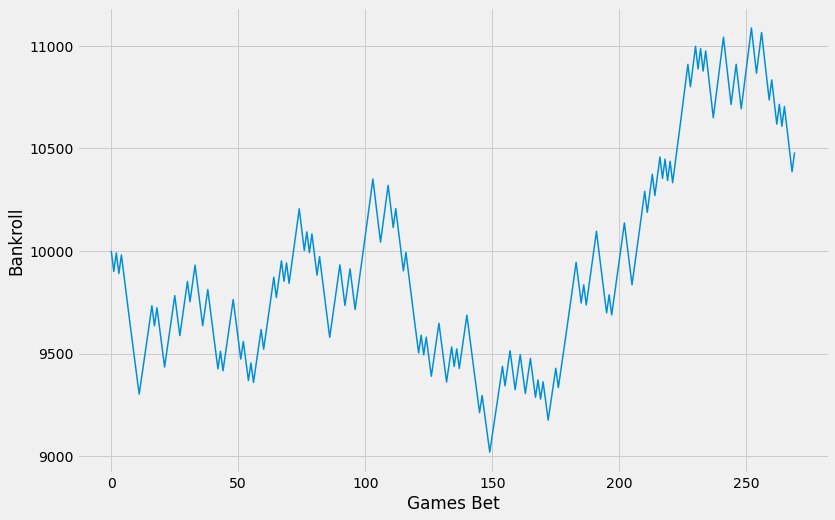

min balance: 9019.578117473284 
max balance: 11086.455161103282 
final balance: 10375.207753199462 
win percentage 53.33


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,33,2015-11-10,WAS,OKC,6.5,101,125,-24,109.642124,110.603324,0.0,-0.961200,1,0,5.538800,10000.000000,100.000000,9900.000000
1,39,2015-11-11,ATL,NOP,-13.0,106,98,8,109.269332,102.105425,0.0,7.163908,0,1,-5.836092,9900.000000,99.000000,9990.000000
2,103,2015-11-20,OKC,NYK,-6.5,90,93,-3,106.754103,95.242829,0.0,11.511274,1,0,5.011274,9990.000000,99.900000,9890.100000
3,207,2015-12-04,WAS,PHX,2.5,109,106,3,108.139846,105.348646,1.0,2.791200,1,1,5.291200,9890.100000,98.901000,9980.010000
4,218,2015-12-05,MIA,CLE,-5.0,99,84,15,98.892339,98.982382,1.0,-0.090042,0,0,-5.090042,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,5967,2020-09-06,MIA,MIL,2.0,115,118,-3,110.440933,107.435668,0.0,3.005265,1,0,5.005265,10703.497939,107.034979,10596.462959
266,5971,2020-09-08,HOU,LAL,4.5,102,112,-10,112.146341,111.275828,0.0,0.870513,1,0,5.370513,10596.462959,105.964630,10490.498330
267,5975,2020-09-10,HOU,LAL,5.5,100,110,-10,111.109656,110.943506,0.0,0.166150,1,0,5.666150,10490.498330,104.904983,10385.593347
268,5991,2020-09-27,MIA,BOS,3.0,125,113,12,109.484320,107.066478,1.0,2.417842,1,1,5.417842,10385.593347,103.855933,10480.007832


In [194]:
pipeline_svr = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs = BayesSearchCV(pipeline_svr, search_spaces=search_spaces, n_jobs=-1, cv=tscv, verbose=3)
svr_bs.fit(X_train, score_train)

print("best estimator:", svr_bs.best_estimator_)
print("best parameters:", svr_bs.best_params_)
best_svr = svr_bs.best_estimator_
svr_preds = best_svr.predict(X_test)

select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

In [ ]:
# Save the Model to file
filename = "../models/svr_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_svr, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    best_svr = pickle.load(file)

best_svr

In [ ]:
select_bets_svr, best_thresholds_svr = find_optimal_threshold(svr_preds, test_indices)
simulate_bets(select_bets_svr)

### Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


RandomForestRegressor(max_depth=24, max_features=0.74300937094178,
                      min_samples_leaf=0.01, min_samples_split=0.01)
best thresholds: (6, 8)
num_games_bet: 692
win percetange at threshold: 0.5317919075144508


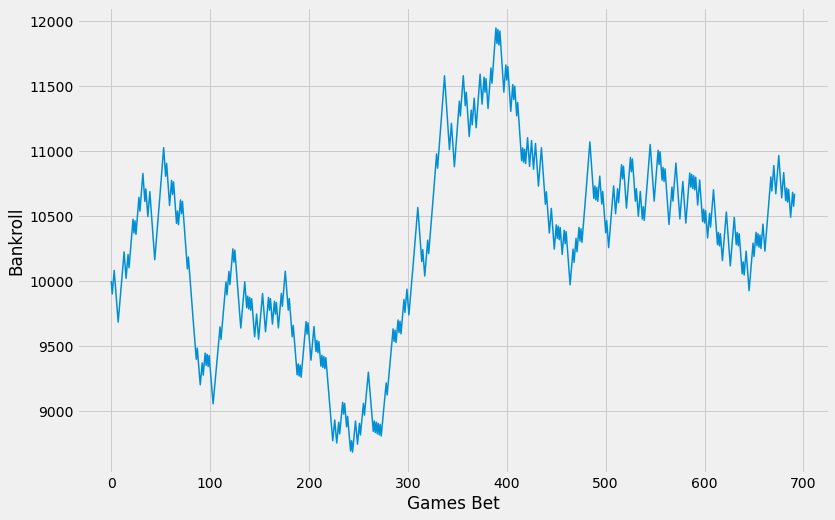

min balance: 8683.49312022547 
max balance: 11946.53310911688 
final balance: 10768.398152943962 
win percentage 53.18000000000001


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,7,2015-11-07,SAS,CHA,-9.5,114,94,20,101.885857,98.725389,1.0,3.160468,0,0,-6.339532,10000.000000,100.000000,9900.000000
1,9,2015-11-07,SAC,GSW,14.0,94,103,-9,102.331922,109.257107,1.0,-6.925184,1,1,7.074816,9900.000000,99.000000,9990.000000
2,10,2015-11-07,UTA,MEM,-2.5,89,79,10,99.790103,90.490152,1.0,9.299952,1,1,6.799952,9990.000000,99.900000,10080.818182
3,15,2015-11-08,POR,DET,-2.0,103,120,-17,103.606390,95.567027,0.0,8.039363,1,0,6.039363,10080.818182,100.808182,9980.010000
4,16,2015-11-08,OKC,PHX,-8.5,124,103,21,106.910098,104.987760,1.0,1.922338,0,0,-6.577662,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,5956,2020-08-31,OKC,HOU,4.5,104,100,4,109.026591,106.608344,1.0,2.418247,1,1,6.918247,10490.464918,104.904649,10585.832781
688,5962,2020-09-03,BOS,TOR,2.5,103,104,-1,109.696034,105.334181,1.0,4.361853,1,1,6.861853,10585.832781,105.858328,10682.067625
689,5971,2020-09-08,HOU,LAL,4.5,102,112,-10,109.751471,106.700389,0.0,3.051082,1,0,7.551082,10682.067625,106.820676,10575.246948
690,5986,2020-09-22,DEN,LAL,6.0,114,106,8,106.746939,105.957619,1.0,0.789320,1,1,6.789320,10575.246948,105.752469,10671.385557


In [195]:
search_spaces = {'max_depth': Integer(2, 30),
              'min_samples_split': Real(0.01, 0.99),
                 'max_features':Real(0.1, 0.99),
                 'min_samples_leaf':Real(0.01, 0.5)
                }  

rf_bscv = BayesSearchCV(RandomForestRegressor(), search_spaces=search_spaces, n_iter=50, cv=tscv, verbose=1, n_jobs=-1)

rf_bscv.fit(X_train, score_train)


best_rf = rf_bscv.best_estimator_
print(best_rf)

best_rf.fit(X_train, score_train)

rf_preds = best_rf.predict(X_test)

select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [63]:
best_rf = RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)
best_rf.fit(X_train, scores_train)

rf_preds = best_rf.predict(X_test)

In [94]:
best_rf.fit(features, scores)

RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)

In [95]:
# Save the Model to file
filename = "../models/rf_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_rf, file)
    


best thresholds: (4, 5)
num_games_bet: 575
win percetange at threshold: 0.5321739130434783


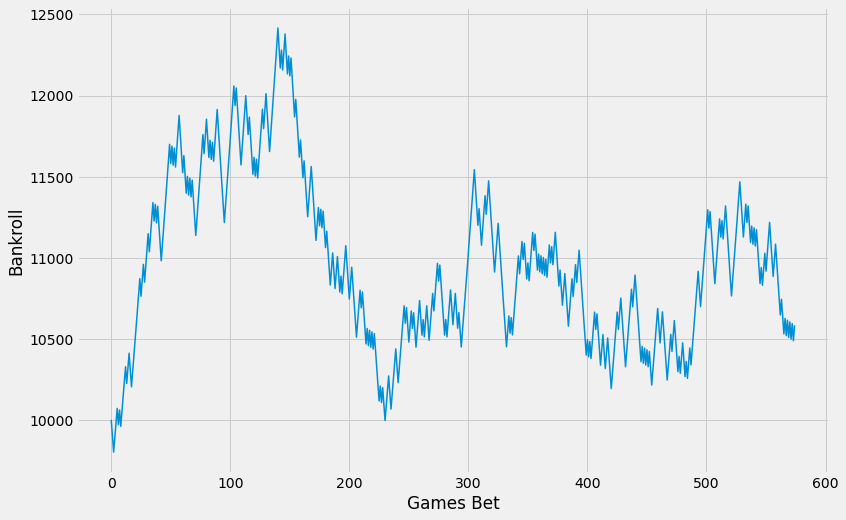

min balance: 9801.0 
max balance: 12416.827886793935 
final balance: 10679.162549581277 
win percentage 53.22


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18112,2015-11-09,GSW,DET,109,95,14,-12.5,1.0,104.738545,96.966817,7.771728,0,0,-4.728272,10000.000000,100.000000,9900.000000
1,18120,2015-11-10,MIA,LAL,101,88,13,-11.0,1.0,103.895754,96.942360,6.953395,0,0,-4.046605,9900.000000,99.000000,9801.000000
2,18125,2015-11-11,HOU,BKN,98,106,-8,-11.5,0.0,107.792015,100.948626,6.843389,0,1,-4.656611,9801.000000,98.010000,9890.100000
3,18139,2015-11-13,NYK,CLE,84,90,-6,7.0,1.0,100.203467,102.643792,-2.440325,1,1,4.559675,9890.100000,98.901000,9980.010000
4,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,102.083858,103.836392,-1.752535,1,1,4.747465,9980.010000,99.800100,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,24053,2020-09-03,LAC,DEN,120,97,23,-9.5,1.0,110.210411,105.375897,4.834515,0,0,-4.665485,10604.151577,106.041516,10498.110061
571,24056,2020-09-05,LAC,DEN,101,110,-9,-9.0,0.0,110.460376,105.463654,4.996722,0,1,-4.003278,10498.110061,104.981101,10593.547425
572,24074,2020-09-18,LAL,DEN,126,114,12,-7.5,1.0,106.956299,104.343853,2.612445,0,0,-4.887555,10593.547425,105.935474,10487.611951
573,24076,2020-09-20,LAL,DEN,105,103,2,-7.5,0.0,107.963541,104.892835,3.070707,0,1,-4.429293,10487.611951,104.876120,10582.953878


In [175]:
select_bets_rf, best_thresholds_rf = find_optimal_threshold(rf_preds, test_indices)
simulate_bets(select_bets_rf)

In [176]:
best_thresholds_rf

,index,confidence_range,num_games_bet,win_percentage
0,14,"(4, 5)",575,0.532174
1,65,"(10, 11)",120,0.533333
2,134,"(14, 16)",28,0.535714
3,135,"(15, 16)",11,0.545455


### XGB

In [200]:
score_train.isnull().sum()

0

In [197]:
search_spaces = {'estimator__min_child_weight':Integer(1,8),
              'estimator__gamma': Real(0.5, 3),
              'estimator__subsample': Real(0.6, 1),
              'estimator__colsample_bytree': Real(0.5, 1),
              'estimator__max_depth': Integer(3, 30),
              'estimator__reg_lambda': Integer(1, 10),
              'estimator__reg_alpha': Integer(0, 10)}
    
    
xgb_bs = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces, cv=tscv, verbose=1, n_jobs=-1)

xgb_bs.fit(X_train, score_train)

print(xgb_bs.best_estimator_)

best_xgb = xgb_bs.best_estimator_
xgb_preds = best_xgb.predict(X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.8s finished


ValueError: array must not contain infs or NaNs

In [ ]:
select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

In [97]:

best_xgb.fit(features, scores)

NameError: name 'nan' is not defined

In [183]:
# Save the Model to file
filename = "../models/xgb_team_score_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_xgb, file)
    
# Load the Model back from file
with open(filename, 'rb') as file:  
    best_xgb = pickle.load(file)

best_xgb

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5, gamma=0.5,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=3,
                                            min_child_weight=6, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=10,
                                            reg_

best thresholds: (11, 13)
num_games_bet: 236
win percetange at threshold: 0.5338983050847458


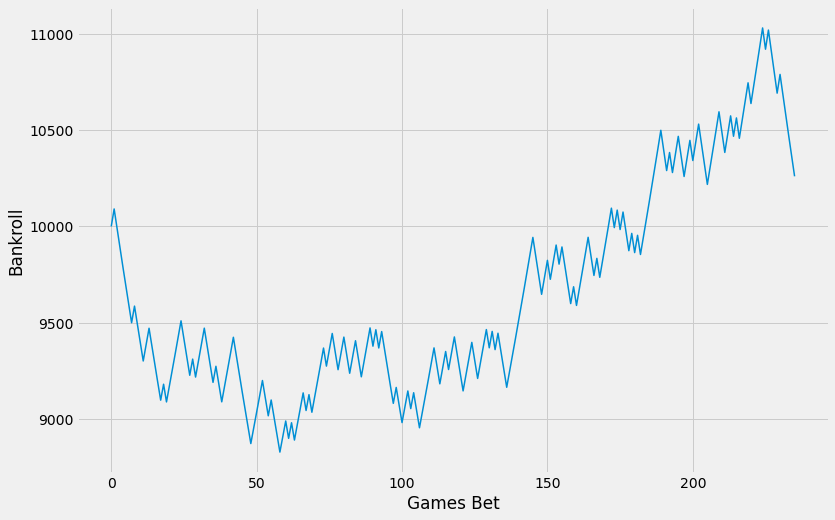

min balance: 8829.246937636215 
max balance: 11030.133546256506 
final balance: 10353.528967276114 
win percentage 53.39


,index,GAME_DATE,home_team,away_team,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,spread,home_cover,home_score_pred,away_score_pred,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,18148,2015-11-13,DEN,HOU,107,98,9,6.5,1.0,107.867104,102.802269,5.064835,1,1,11.564835,10000.000000,100.000000,10090.909091
1,18190,2015-11-20,DEN,PHX,107,114,-7,3.0,0.0,107.781609,99.109589,8.672020,1,0,11.672020,10090.909091,100.909091,9990.000000
2,18262,2015-11-29,TOR,PHX,102,107,-5,-3.0,0.0,112.053307,97.325027,14.728279,1,0,11.728279,9990.000000,99.900000,9890.100000
3,18268,2015-11-30,MIL,DEN,92,74,18,-4.0,1.0,93.772675,100.842636,-7.069962,0,0,-11.069962,9890.100000,98.901000,9791.199000
4,18343,2015-12-10,BKN,PHI,100,91,9,-7.0,1.0,90.809036,96.231415,-5.422379,0,0,-12.422379,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,24009,2020-08-17,BOS,PHI,109,101,8,-6.5,1.0,98.999809,103.738457,-4.738647,0,0,-11.238647,10681.133197,106.811332,10574.321865
232,24015,2020-08-19,BOS,PHI,128,101,27,-4.5,1.0,96.721703,103.466515,-6.744812,0,0,-11.244812,10574.321865,105.743219,10468.578647
233,24028,2020-08-22,ORL,MIL,107,121,-14,12.5,0.0,113.059914,114.500946,-1.441032,1,0,11.058968,10468.578647,104.685786,10363.892860
234,24039,2020-08-25,LAC,DAL,154,111,43,-8.5,1.0,106.753502,110.046539,-3.293037,0,0,-11.793037,10363.892860,103.638929,10260.253932


In [181]:
select_bets_xgb, best_thresholds_xgb = find_optimal_threshold(xgb_preds, test_indices)
simulate_bets(select_bets_xgb)

### ADABoost

In [201]:
ada = AdaBoostRegressor()

search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_gs = BayesSearchCV(ada, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_gs.fit(X_train, score_train)


best_ada = ada_gs.best_estimator_
print(ada_gs.best_params_)
print(best_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.2min finished


OrderedDict([('learning_rate', 0.02978413312793186), ('loss', 'exponential'), ('n_estimators', 500)])
AdaBoostRegressor(learning_rate=0.02978413312793186, loss='exponential',
                  n_estimators=500)


best thresholds: (9, 18)
num_games_bet: 379
win percetange at threshold: 0.5303430079155673


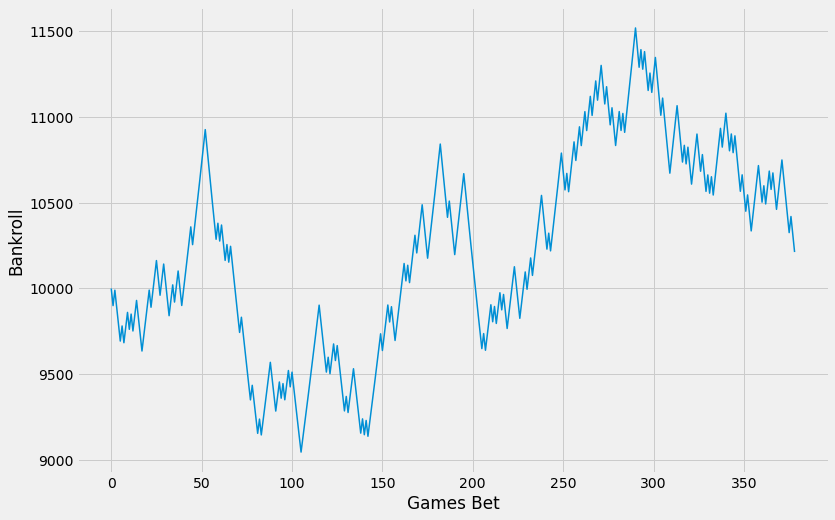

min balance: 9045.870878242558 
max balance: 11519.198926569561 
final balance: 10305.134339245005 
win percentage 53.03


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,2,2015-11-06,SAC,HOU,4.5,110,116,-6,111.117014,105.098627,0.0,6.018388,1,0,10.518388,10000.000000,100.000000,9900.000000
1,3,2015-11-06,GSW,DEN,-17.5,119,104,15,107.263205,99.135157,0.0,8.128049,0,1,-9.371951,9900.000000,99.000000,9990.000000
2,21,2015-11-09,GSW,DET,-12.5,109,95,14,103.112764,99.689143,1.0,3.423621,0,0,-9.076379,9990.000000,99.900000,9890.100000
3,160,2015-11-28,GSW,SAC,-16.5,120,101,19,110.338639,104.534804,1.0,5.803836,0,0,-10.696164,9890.100000,98.901000,9791.199000
4,196,2015-12-02,CHA,GSW,9.0,99,116,-17,105.000000,104.983698,0.0,0.016302,1,0,9.016302,9791.199000,97.911990,9693.287010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,5943,2020-08-24,ORL,MIL,13.0,106,121,-15,111.013256,113.842818,0.0,-2.829562,1,0,10.170438,10430.076328,104.300763,10325.775565
375,5950,2020-08-29,LAL,POR,-14.0,131,122,9,114.951772,111.531754,0.0,3.420018,0,1,-10.579982,10325.775565,103.257756,10419.646252
376,5953,2020-08-30,DAL,LAC,9.5,97,111,-14,114.252153,113.510838,0.0,0.741314,1,0,10.241314,10419.646252,104.196463,10315.449789
377,5961,2020-09-03,LAC,DEN,-9.5,120,97,23,111.013256,113.495060,1.0,-2.481804,0,0,-11.981804,10315.449789,103.154498,10212.295291


In [202]:
ada_preds = best_ada.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_preds, test_indices)
simulate_bets(select_bets_ada)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


OrderedDict([('learning_rate', 0.12645966693687635), ('loss', 'exponential'), ('n_estimators', 50)])
AdaBoostRegressor(base_estimator=Lasso(), learning_rate=0.12645966693687635,
                  loss='exponential')
best thresholds: (7, 19)
num_games_bet: 305
win percetange at threshold: 0.5377049180327869


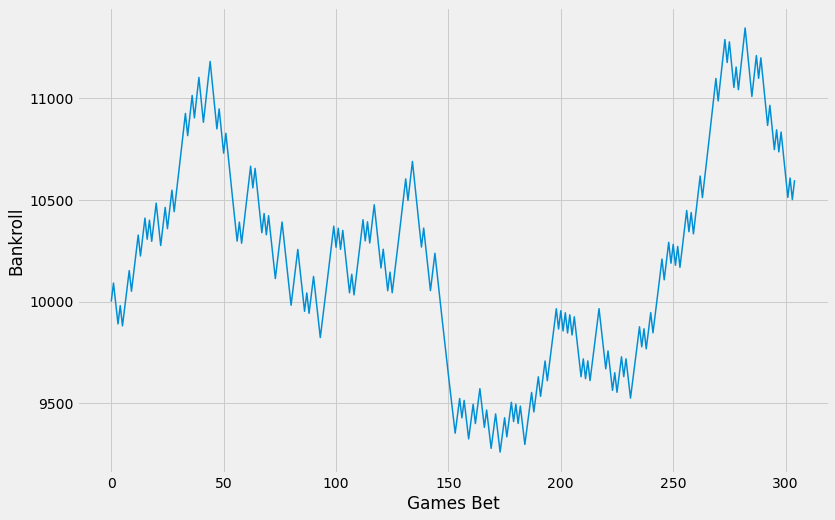

min balance: 9258.961560043826 
max balance: 11346.586447714079 
final balance: 10693.76394742357 
win percentage 53.769999999999996


,index,GAME_DATE,home_team,away_team,spread,HOME_SCORE,AWAY_SCORE,point_diff,pred_home,pred_away,home_cover,point_diff_pred,bet_home,bet_won,confidence,bankroll_i,bet_size,bankroll_n
0,39,2015-11-11,ATL,NOP,-13.0,106,98,8,111.830797,106.546393,0.0,5.284403,0,1,-7.715597,10000.000000,100.000000,10090.909091
1,218,2015-12-05,MIA,CLE,-5.0,99,84,15,97.766586,100.800941,1.0,-3.034355,0,0,-8.034355,10090.909091,100.909091,9990.000000
2,323,2015-12-19,NYK,CHI,-2.5,107,91,16,101.275644,106.203952,1.0,-4.928308,0,0,-7.428308,9990.000000,99.900000,9890.100000
3,336,2015-12-21,ATL,POR,-11.0,106,97,9,103.537120,100.804845,0.0,2.732275,0,1,-8.267725,9890.100000,98.901000,9980.010000
4,345,2015-12-23,NOP,POR,-7.5,115,89,26,103.459060,103.803383,1.0,-0.344323,0,0,-7.844323,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,5943,2020-08-24,ORL,MIL,13.0,106,121,-15,114.321486,120.229806,0.0,-5.908321,1,0,7.091679,10618.650414,106.186504,10512.463910
301,5950,2020-08-29,LAL,POR,-14.0,131,122,9,118.112667,112.846284,0.0,5.266382,0,1,-8.733618,10512.463910,105.124639,10608.031763
302,5972,2020-09-08,MIL,MIA,5.5,94,103,-9,111.880184,109.714385,0.0,2.165799,1,0,7.665799,10608.031763,106.080318,10501.951446
303,5993,2020-10-02,LAL,MIA,-11.0,124,114,10,112.010559,108.200753,0.0,3.809806,0,1,-7.190194,10501.951446,105.019514,10597.423732


In [205]:
ada_lasso = AdaBoostRegressor(Lasso())
search_spaces = {'learning_rate': Real(0.01,1, prior='log-uniform'),
                'loss': Categorical(['linear', 'square', 'exponential']), 
                'n_estimators': Integer(50, 500)}

ada_lasso_gs = BayesSearchCV(ada_lasso, search_spaces=search_spaces, n_iter=50, cv=tscv, n_jobs=-1, verbose=1)
ada_lasso_gs.fit(X_train, score_train)

best_ada_lasso = ada_lasso_gs.best_estimator_
print(ada_lasso_gs.best_params_)
print(best_ada_lasso)

ada_lasso_preds = best_ada_lasso.predict(X_test)
select_bets_ada, best_thresholds_ada= find_optimal_threshold(ada_lasso_preds, test_indices)
simulate_bets(select_bets_ada)

In [ ]:
ada_lasso_preds = ada_lasso.predict(X_test)
select_bets_ada_lasso, best_thresholds_ada_lasso= find_optimal_threshold(ada_lasso_preds, test_indices)
simulate_bets(select_bets_ada_lasso)


### Stacking Regressor

In [70]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])
ada_lasso = MultiOutputRegressor(AdaBoostRegressor(base_estimator = Pipeline([('scaler', StandardScaler()),
                        ('lasso', Lasso(alpha=0.18149))])))

ada = MultiOutputRegressor(AdaBoostRegressor())

best_rf = RandomForestRegressor(max_depth=17, max_features=0.6334551200752405,
                      min_samples_leaf=0.01, min_samples_split=0.01)

lr_pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

estimators = [lasso_pipeline, ada_lasso, ada, best_rf, lr_pipeline]

stacked_clf = StackingRegressor(estimators=estimators, final_estimator = LinearRegression(), verbose=2, n_jobs=-1)

stacked_clf.fit(X_train, scores_train)


stacked_preds = stacked_clf.predict(X_test)



TypeError: zip argument #2 must support iteration

In [ ]:
select_bets_stacked, best_thresholds_stacked = find_optimal_threshold(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

## Using Model

In [71]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data(season='2020-21')
df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,L,240,38,81,0.469,9,29,0.310,24,31,0.774,8,37,45,22,4,2,19,20,109,-7,103.2,104.8,109.1,111.5,-5.9,-6.7,0.579,1.16,16.2,0.250,0.731,0.510,17.986,18.3,0.525,0.576,1.0,0.199,106.00,104.0,86.67,104,0.509,0.642,0.358,0.532,0.183,0.248,0.110,0.220,0.174,0.349,0.586,0.414,0.556,0.444,0.579,0.421
1,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,W,240,44,93,0.473,14,40,0.350,14,19,0.737,11,29,40,22,10,3,16,29,116,7,109.1,111.5,103.2,104.8,5.9,6.7,0.500,1.38,15.8,0.269,0.750,0.490,15.043,15.4,0.548,0.572,1.0,0.198,106.00,104.0,86.67,104,0.491,0.570,0.430,0.517,0.086,0.362,0.138,0.121,0.138,0.431,0.433,0.567,0.643,0.357,0.500,0.500
2,2020-21,22020,1610612744,GSW,Golden State Warriors,22000001,2020-12-22,GSW @ BKN,L,240,37,99,0.374,10,33,0.303,15,23,0.652,13,34,47,26,6,6,18,24,99,-26,86.8,88.4,110.5,111.6,-23.8,-23.2,0.703,1.44,17.0,0.281,0.685,0.466,15.773,16.1,0.424,0.454,1.0,0.201,113.60,112.0,93.33,112,0.350,0.667,0.333,0.545,0.101,0.303,0.121,0.152,0.192,0.444,0.630,0.370,0.900,0.100,0.703,0.297
3,2020-21,22020,1610612751,BKN,Brooklyn Nets,22000001,2020-12-22,BKN vs. GSW,W,240,42,92,0.457,15,35,0.429,26,32,0.813,13,44,57,24,11,7,20,22,125,26,110.5,111.6,86.8,88.4,23.8,23.2,0.571,1.20,16.0,0.315,0.719,0.534,17.687,17.9,0.538,0.589,1.0,0.201,113.60,112.0,93.33,112,0.650,0.620,0.380,0.432,0.064,0.360,0.224,0.208,0.184,0.368,0.481,0.519,0.733,0.267,0.571,0.429
4,2020-21,22020,1610612755,PHI,Philadelphia 76ers,22000013,2020-12-23,PHI vs. WAS,W,240,41,87,0.471,8,28,0.286,23,30,0.767,10,37,47,22,11,8,18,25,113,6,104.4,104.6,97.2,100.0,7.3,4.6,0.537,1.22,15.7,0.280,0.816,0.545,16.636,16.7,0.517,0.564,1.0,0.198,109.16,107.5,89.58,108,0.538,0.678,0.322,0.584,0.124,0.212,0.106,0.204,0.212,0.460,0.424,0.576,1.000,0.000,0.537,0.463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2020-21,22020,1610612745,HOU,Houston Rockets,22000578,2021-03-11,HOU @ SAC,L,240,41,99,0.414,11,45,0.244,12,17,0.706,10,34,44,24,7,6,13,22,105,-20,95.9,99.1,112.3,116.8,-16.4,-17.8,0.585,1.85,16.7,0.250,0.729,0.463,11.874,12.3,0.470,0.493,1.0,0.201,110.40,106.5,88.75,106,0.386,0.545,0.455,0.571,0.019,0.314,0.190,0.114,0.105,0.552,0.533,0.467,0.727,0.273,0.585,0.415
1088,2020-21,22020,1610612744,GSW,Golden State Warriors,22000576,2021-03-11,GSW @ LAC,L,240,38,88,0.432,9,36,0.250,19,27,0.704,5,39,44,20,6,6,16,23,104,-26,93.8,95.4,119.5,118.2,-25.7,-22.8,0.526,1.25,14.7,0.148,0.764,0.459,14.430,14.7,0.483,0.521,1.0,0.200,109.82,109.5,91.25,109,0.380,0.591,0.409,0.558,0.115,0.260,0.135,0.183,0.096,0.442,0.379,0.621,1.000,0.000,0.526,0.474
1089,2020-21,22020,1610612746,LAC,LA Clippers,22000576,2021-03-11,LAC vs. GSW,W,240,44,96,0.458,18,41,0.439,24,29,0.828,11,45,56,23,10,6,11,22,130,26,119.5,118.2,93.8,95.4,25.7,22.8,0.523,2.09,16.1,0.236,0.852,0.541,10.114,10.0,0.552,0.598,1.0,0.200,109.82,109.5,91.25,110,0.620,0.573,0.427,0.400,0.108,0.415,0.115,0.185,0.185,0.292,0.385,0.615,0.722,0.278,0.523,0.477
1090,2020-21,22020,1610612752,NYK,New York Knicks,22000573,2021-03-11,NYK @ MIL,L,240,37,88,0.420,13,37,0.351,14,21,0.667,10,28,38,19,3,5,15,19,101,-33,98.8,100.0,132.0,1

In [72]:
from src.models.model_preparation import avg_data_for_model
from src.data.make_team_dataset import create_matchups, prep_for_aggregation
from src.features.build_team_features import add_percentage_features, add_rest_days

df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = avg_data_for_model(df1)
df1 = add_percentage_features(df1)
df1 = add_rest_days(df1)

new_cols = []
for col in df1.columns:
    if col.endswith('team'):
        col = col[:-5]
    
    new_cols.append(col)
df1.columns = new_cols
# df1 = df1.loc[df1['HOME_GAME'] == 1]
df1.sort_values('GAME_DATE')
df1

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM,OREB_PCT,DREB_PCT,REB_PCT,TS_PCT,EFG_PCT,AST_RATIO,TOV_PCT,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000002,2020-12-22,LAL vs. LAC,1,109,-7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000008,2020-12-25,LAL vs. DAL,1,138,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000040,2020-12-27,LAL vs. MIN,1,127,36,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000045,2020-12-28,LAL vs. POR,1,107,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2020-21,22020,1610612747,LAL,Los Angeles Lakers,22000060,2020-12-30,LAL @ SAS,0,121,14,1,240.0,0.6,32.2,55.0,13.0,31.2,17.0,22.2,8.6,37.8,46.4,26.4,5.8,5.6,17.0,20.0,120.4,11.6,115.52,117.52,105.04,106.22,10.48,11.30,102.4,0.5590,14.2,17.6,14.6,49.2,15.2,16.0,9.8,2.4,0.218274,0.807692,0.538283,0.660928,0.599768,25.781250,15.048509,240.0,0.4,29.4,56.2,11.8,35.4,14.6,19.4,9.0,30.8,39.8,23.6,10.2,4.4,12.8,21.8,108.8,-11.6,105.04,106.22,115.52,117.52,-10.48,-11.30,102.6,0.4410,8.8,15.0,18.8,49.2,14.4,14.0,8.2,3.0,0.192308,0.781726,0.461717,0.567447,0.514192,23.001949,11.333853,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000510,2021-02-26,OKC vs. ATL,1,118,9,1,242.5,0.4,25.5,49.7,13.4,36.6,14.3,19.3,7.7,36.5,44.2,25.2,6.9,2.9,14.3,19.3,105.5,-1.7,104.00,106.19,107.16,108.18,-3.15,-1.99,99.3,0.4777,6.3,7.4,15.0,43.9,14.1,10.6,10.3,2.6,0.173034,0.773305,0.482007,0.582577,0.528389,25.377644,13.108202,242.5,0.6,28.4,52.6,12.0,36.0,14.4,19.5,10.7,36.8,47.5,24.3,7.8,5.4,13.6,16.7,107.2,1.7,107.16,108.

In [73]:
prev_season_final_elo = {}
for team in full_df['TEAM_ABBREVIATION'].unique():
    team_df = full_df.loc[full_df['TEAM_ABBREVIATION'] == team].sort_values('GAME_DATE').reset_index(drop=True)
    final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'HOU': 1592.8061316925175,
 'POR': 1494.4500286882749,
 'CHA': 1336.0857158848346,
 'PHX': 1467.1433716661513,
 'MIN': 1334.876543008371,
 'LAC': 1585.2027933871393,
 'DAL': 1489.78112835511,
 'MIL': 1691.6267378675223,
 'BKN': 1446.9855523900742,
 'CHI': 1310.9827810845577,
 'IND': 1568.7574184503267,
 'PHI': 1590.9391782685086,
 'NYK': 1295.8334651599992,
 'CLE': 1254.4277334029882,
 'SAS': 1511.9475234777801,
 'GSW': 1296.509281737069,
 'SAC': 1463.3998161359382,
 'DET': 1325.3640523411293,
 'DEN': 1596.5965930440295,
 'LAL': 1622.585614793648,
 'OKC': 1595.2859561422845,
 'ATL': 1338.5855784973007,
 'MIA': 1634.7362170560314,
 'BOS': 1682.7827251651756,
 'UTA': 1558.6788333810905,
 'TOR': 1643.0408253093453,
 'WAS': 1368.8271472091822,
 'MEM': 1535.502184890209,
 'ORL': 1441.2580581243433,
 'NOP': 1478.3966107929218}

In [74]:
# Add ELO ratings

def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE']
        away_score = home_score - row['point_diff']
        home_rating = elo_dic[team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, prev_season_final_elo)


progress:: 542it [00:00, 723.65it/s]


In [75]:
def create_matchup_row(df, away_team, home_team):
    home_team = df.loc[df['TEAM_ABBREVIATION'] == home_team].sort_values('GAME_DATE')
    away_team = df.loc[df['TEAM_ABBREVIATION'] == away_team].sort_values('GAME_DATE')
    
    home_cols = ["HOME_" + col for col in home_team.columns]
    away_cols = ["AWAY_" + col for col in away_team.columns]    
    home_cols.extend(away_cols)

    home_last = home_team.iloc[-1].values.reshape(1, -1)
    away_last = away_team.iloc[-1].values.reshape(1, -1)
    
    matchup_row = np.concatenate([home_last, away_last], axis=1)
    
    df_row = pd.DataFrame(matchup_row, columns = home_cols)
    
    # Add ELO Rating
    home_team_abbr = df_row['HOME_TEAM_ABBREVIATION'].values[0]
    away_team_abbr = df_row['AWAY_TEAM_ABBREVIATION'].values[0]
    df_row['home_rating_i'] = elo_ratings_dic[home_team_abbr]
    df_row['away_rating_i'] = elo_ratings_dic[away_team_abbr]
    df_row['home_elo_pred'] = elo_prediction(df_row['home_rating_i'].values[0], df_row['away_rating_i'].values[0])
    df_row['elo_MOV_pred'] =  round((df_row['home_rating_i'].values[0]+100 - df_row['away_rating_i'].values[0])/28, 2)
        
    return df_row



In [76]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

Updating 13 Games


progress:   0%|                                                                                 | 0/13 [00:00<?, ?it/s]

updating scoring boxscores
Updating 13 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.82s/it]


updating tracking boxscores
Updating 13 Games


progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

Updating lines for 2 days


progress:   0%|                                                                                  | 0/2 [00:00<?, ?it/s]

Updating lines for 2 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:24<00:00, 12.19s/it]


In [77]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,DET,BKN,2021-03-13,11.5-115,11.5-111,11.0,11.0,-11.5,-11.5,-11.0,-11.0,11,-11.5
1,MIL,WAS,2021-03-13,-13-115,-13-111,-13.0,-13.0,13.0,13.0,13.0,13.0,-13,13.0
2,TOR,CHA,2021-03-13,2.5-105,3-110,2.5,2.5,-2.5,-3.0,-2.5,-2.5,2.5,-2.5
3,SAC,ATL,2021-03-13,4-105,4-109,4.0,4.0,-4.0,-4.0,-4.0,-4.0,4,-4.0
4,POR,MIN,2021-03-13,-5-115,-5-115,-5.0,-5.5,5.0,5.0,5.0,5.5,-5.5,5.0
5,DAL,DEN,2021-03-13,-2-110,-2-110,-1.5,-1.0,2.0,2.0,1.5,1.0,-2-110,2.0
6,IND,PHX,2021-03-13,7.5-115,7.5-107,7.5,7.0,-7.5,-7.5,-7.5,-7.0,7,-7.5
7,NYK,OKC,2021-03-13,-5-110,-4.5-110,-4.5,-4.5,5.0,4.5,4.5,4.5,-4.5,4.5


In [78]:
X_train

,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,0.4,26.8,59.4,5.8,16.2,23.0,29.4,11.8,27.4,39.2,19.0,8.6,4.2,16.6,22.0,94.0,3.2,100.72,103.16,98.42,99.20,2.28,3.94,91.0,0.5110,18.0,7.0,18.2,34.6,14.2,12.0,4.6,1.0,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,0.6,29.6,62.0,4.8,13.2,17.2,24.0,10.2,28.8,39.0,20.4,6.6,4.4,16.6,23.0,90.8,-3.2,98.42,99.20,100.72,103.16,-2.28,-3.94,91.4,0.4890,23.2,7.8,17.6,35.2,15.6,13.4,4.4,0.2,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,0.8,31.4,69.8,3.6,12.0,22.4,30.4,12.8,32.4,45.2,22.8,9.8,3.8,16.2,24.0,96.0,8.4,97.46,99.48,90.12,90.34,7.36,9.12,96.6,0.5760,25.6,9.8,20.8,36.0,19.0,11.8,3.4,0.2,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,0.2,30.6,67.8,3.6,13.2,15.6,23.0,13.2,31.0,44.2,18.0,8.6,8.0,19.4,25.2,87.6,-8.4,90.12,90.34,97.46,99.48,-7.36,-9.12,97.0,0.4240,15.4,10.4,16.2,44.6,14.8,15.2,2.8,0.6,0.289474,0.707763,0.494407,0.508947,0.444444,18.556701,17.553384,1.0,0.640065,1300.000000,1300.000000,3.57
1,0.4,31.0,69.6,4.2,12.6,12.8,16.0,13.6,29.0,42.6,23.4,7.8,7.6,17.6,25.8,87.4,-4.8,93.64,94.84,99.02,100.98,-5.40,-6.12,92.0,0.4580,24.6,16.0,17.2,36.6,19.2,11.2,3.8,0.4,0.323810,0.710784,0.514493,0.509799,0.453771,25.434783,16.473231,0.6,29.8,62.6,4.2,14.8,20.0,27.0,11.8,28.4,40.2,23.0,9.2,5.0,15.6,19.0,92.2,4.8,99.02,100.98,93.64,94.84,5.40,6.12,91.4,0.5420,17.4,15.4,19.0,41.2,18.8,10.0,3.8,0.2,0.289216,0.676190,0.485507,0.553156,0.466408,25.164114,14.874142,2.0,0.4,31.2,66.0,5.4,18.0,22.2,30.6,12.6,26.8,39.4,23.4,8.2,7.0,15.0,26.2,100.8,-4.4,101.00,102.72,103.54,107.86,-2.54,-5.14,98.2,0.4646,17.8,16.0,21.4,43.2,18.6,12.0,4.2,1.0,0.28

In [79]:
create_matchup_row(df1, 'HOU', 'UTA')

,HOME_SEASON_YEAR,HOME_SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,HOME_GAME_ID,HOME_GAME_DATE,HOME_MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_point_diff,HOME_WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_SEASON_YEAR,AWAY_SEASON_ID,AWAY_TEAM_ID,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_NAME,AWAY_GAME_ID,AWAY_GAME_DATE,AWAY_MATCHUP,AWAY_HOME_GAME,AWAY_TEAM_SCORE,AWAY_point_diff,AWAY_WL,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_rating_i,away_rating_i,home_elo_pred,elo_MOV_pred
0,2020-21,22020,1610612762,UTA,Utah Jazz,22000545,2021-03-03,UTA @ PHI,0,123,-8,0,242.5,0.6,25.3,46.1,17.5,44.6,17.4,21.7,10.4,34.8,45.2,23.9,8.2,4.2,13.2,19.2,120.5,8.4,117.11,117.94,109.39,109.64,7.73,8.32,102.3,0.5293,3.7,13.1,14,45.7,10.7,13.7,12.4,4.2,0.228571,0.783784,0.502781,0.631062,0.568357,23.3627,11.6353,242.5,0.4,32.5,61.1,10.1,28.5,16.8,21.2,9.6,35.1,44.7,21.8,7,3.4,13,18.4,112.1,-8.4,109.39,109.64,117.11,117.94,-7.73,-8.32,102.1,0.4707,12.5,13.3,16.5,51.5,13.2,18.5,8.1,1.6,0.216216,0.771429,0.497219,0.594607,0.531808,21.3516,11.6146,2,2020-21,22020,1610612745,HOU,Houston Rockets,22000578,2021-03-11,HOU @ SAC,0,105,-20,0,240,0,25,48.6,11.3,41.1,19.2,24.8,9.5,29.6,39.1,19.8,8.3,5.4,13.1,20,103.1,-18.4,99.08,100.95,116.19,118,-17.07,-17.07,102.3,0.3825,4.3,9.2,19,44.8,9.7,14.5,9.3,1.6,0.184466,0.774869,0.435897,0.541742,0.46767,19.3548,11.5203,240,1,31.3,54.3,13.1,32.5,19.6,24.2,8.6,42,50.6,25.4,8.4,5,15.8,21.5,121.5,18.4,116.19,118,99.08,100.95,17.07,17.07,103,0.6175,7.4,16.3,16.4,54.2,14.6,16,10.1,2.8,0.225131,0.815534,0.564103,0.659437,0.586982,24.6602,13.9517,8,1671.087948,1383.896993,0.839324,13.83


### Make Predictions

In [91]:
# Load Saved Models

loaded_lr = pickle.load(open('../models/linreg_team_score_model.pkl', 'rb'))
loaded_lasso = pickle.load(open('../models/best_lasso.pkl', 'rb'))
loaded_rf = pickle.load(open("../models/rf_team_score_model.pkl", 'rb'))


In [171]:
def make_prediction(df, away_team, home_team):
    matchup_row = create_matchup_row(df, away_team, home_team)
    matchup_row = matchup_row[features.columns.tolist()]
    matchup_row = matchup_row.astype(float) 
    lr_pred = pipeline.predict(matchup_row)
    rf_pred = rf.predict(matchup_row)
    lasso_preds = loaded_lasso.predict(matchup_row)
    return lr_pred, rf_pred

    
away_teams = []
home_teams = []
spreads = []
lr_home = []
lr_away = []
rf_home = []
rf_away = []
for idx, row in todays_spreads.iterrows():
    away_team = row['away_team']
    home_team = row['home_team']
    spread = row['home_spread_mode']
    lr_pred, rf_pred = make_prediction(df1, away_team, home_team)
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    lr_home.append(lr_pred[0][0])
    lr_away.append(lr_pred[0][1])
    rf_home.append(rf_pred[0][0])
    rf_away.append(rf_pred[0][1])
    
todays_betting_preds = pd.DataFrame({'away_team':away_teams,
                                     'home_team':home_teams,
                                     'spread':spreads,
                                     'lr_home':lr_home,
                                     'lr_away':lr_away,
                                     'rf_home':rf_home,
                                     'rf_away':rf_away})

todays_betting_preds['lr_diff'] = todays_betting_preds['lr_home'] - todays_betting_preds['lr_away']
todays_betting_preds['rf_diff'] = todays_betting_preds['rf_home'] - todays_betting_preds['rf_away']
todays_betting_preds['lr_confidence'] = todays_betting_preds['lr_diff'] + todays_betting_preds['spread']
todays_betting_preds['rf_confidence'] = todays_betting_preds['rf_diff'] + todays_betting_preds['spread']

todays_betting_preds

,away_team,home_team,spread,lr_home,lr_away,rf_home,rf_away,lr_diff,rf_diff,lr_confidence,rf_confidence
0,CLE,NOP,-6.5,118.705093,111.243230,113.45,106.77,7.461864,6.68,0.961864,0.18
1,PHI,WAS,3.0,117.564468,120.194646,113.83,114.30,-2.630177,-0.47,0.369823,2.53
2,DEN,MEM,3.0,113.939468,115.116521,110.37,108.74,-1.177052,1.63,1.822948,4.63
3,ORL,SAS,-7.5,112.455093,107.944646,111.32,103.75,4.510448,7.57,-2.989552,0.07
4,MIA,CHI,2.0,108.900406,114.546208,108.25,108.44,-5.645802,-0.19,-3.645802,1.81
5,HOU,UTA,-19.0,119.955093,110.378239,115.69,105.13,9.576854,10.56,-9.423146,-8.44
6,IND,LAL,-4.5,112.884781,107.241521,108.64,103.06,5.643260,5.58,1.143260,1.08
